This notebook performs some statistical analysis of the data collected.  Baseball batting data has been downloaded from the Layman site.  Sean Layman has done a fantastic job at collecting raw data collected from 1871 to 2018 of major league baseball games. All atomic data elements needed for the calculation of OPS (on base plus slug), OBP (on base percentage) and SLG (slugging) are available in this data. The baseball data has been wrangled into a format for consumption and validations have been run against the data to verify its accuracy.  The data was validated against Fangraphs data from multiple years.  

Next, data discovery was performed and can be viewed with the following link:

https://nbviewer.jupyter.org/github/paulscheibal/SBDataScienceCert/blob/master/CapstoneP1/Discovery/DataStory.ipynb

The goal of this Jupyter Notebooks is to answer some fundamental questions in a statistical manner such as

1) What does the OPS data collected from 1954 to 2018 look like graphicaly.  And does it appear to be normally distributed.   I    will show this visually via QQ, PDF and CDF plots as well as use the D'Agostinos K^2 Test and the Anderson Darling Test for whether a the collected data was drawn from the normal distribution.

2) The mean of the sampling distribution means of OPS data will be analyzed for its closeness to normal distribution.

3) A series of tests will be run on data collected to determine any correlations using the Pearson Correlation.  Data will be viewed graphically as well.

Let's dive right in and view the collected OPS data in a histogram with a normal distribution plot overlay, the OPS CDF against the empirical normal CDF and the QQ plot.




The sample mean of the data is : 0.6767 with sample std dev : 0.168

The size of the sample is 31570





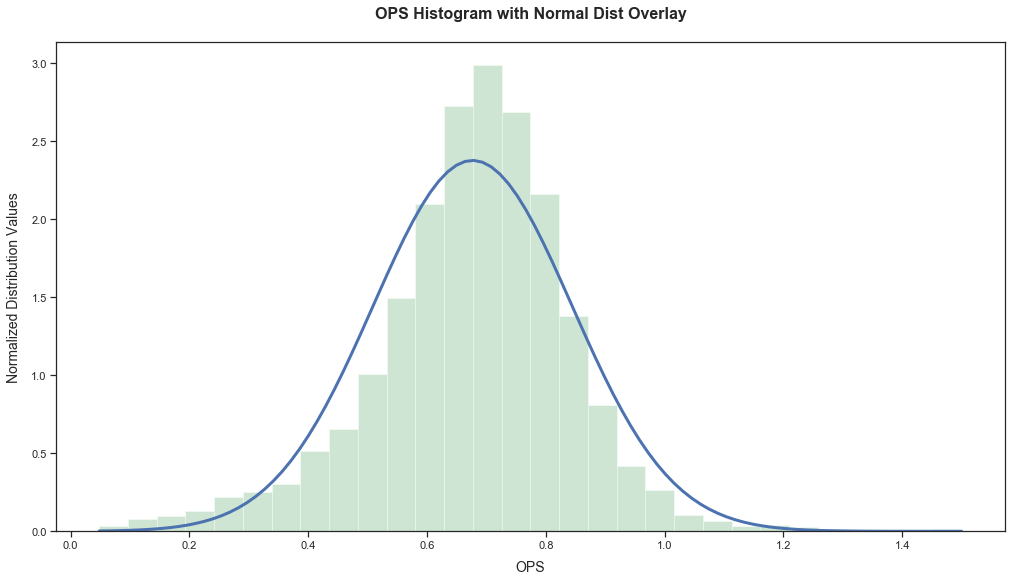

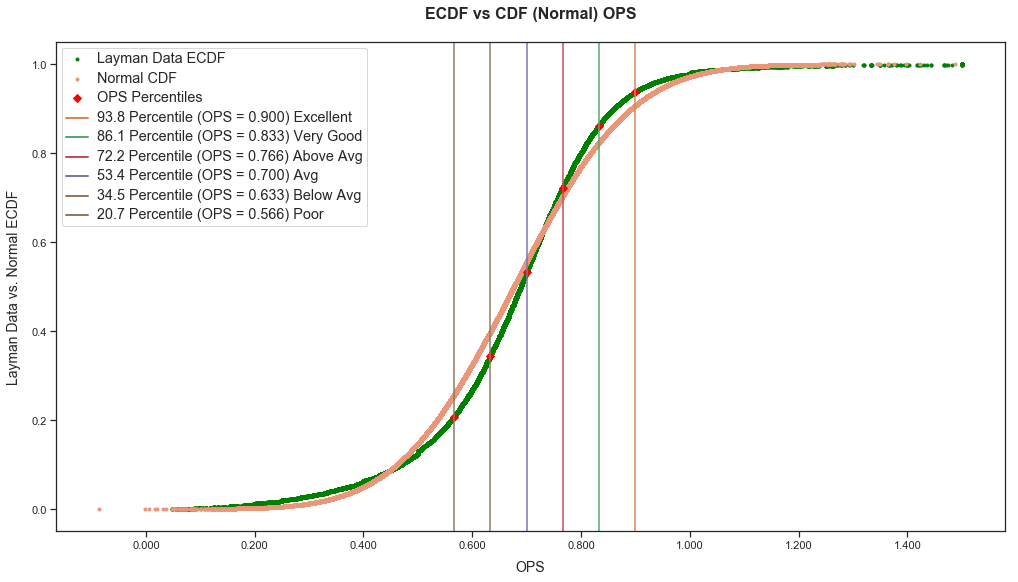

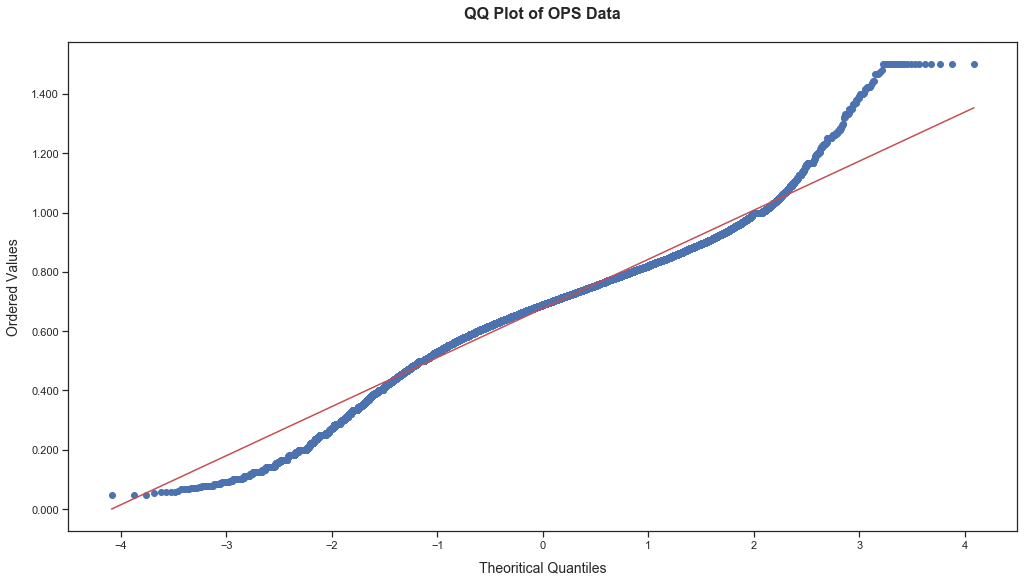




Two Tests for Null Hypothesis (H0) that Layman OPS population data is Normal


DAgostinos K^2 Test:

Statistics=1630.113, p=0.000
Data does not look normal (reject H0)


Anderson Darling Test:

Statistic: 217.140
15.000: 0.576, Data does not look normal (reject H0)
10.000: 0.656, Data does not look normal (reject H0)
5.000: 0.787, Data does not look normal (reject H0)
2.500: 0.918, Data does not look normal (reject H0)
1.000: 1.092, Data does not look normal (reject H0)





In [8]:
# -*- coding: utf-8 -*-
"""
Created on Wed Sep 18 12:31:14 2019

@author: User
"""

import pandas as pd
import numpy as np
from datetime import datetime
import os.path
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl
import pylab as plb
import seaborn as sns
import matplotlib.mlab as mlab
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import anderson
from scipy.stats import normaltest
from scipy.stats import probplot
import math
from numpy.random import seed

sns.set()
sns.set_style('ticks')

MIN_AT_BATS = 0
START_YEAR = 1954
END_YEAR = 2018
FSHZ = 17
START_DATE = datetime.strptime(str(START_YEAR)+'-01-01','%Y-%m-%d')
END_DATE = datetime.strptime(str(END_YEAR)+'-12-31','%Y-%m-%d')
LEGEND_PROPERTIES = {'weight':'bold'}
 

# set path for reading Lahman baseball statistics
path = 'C:\\Users\\User\\Documents\\PAUL\\Springboard\\core\\'
bigcontractsfile = 'BigPlayerContractsMLB.csv'

battingf = path + 'dfbatting_player_stats.csv'
dfbatting_player_stats = pd.read_csv(battingf,parse_dates=['debut','finalGame','birthdate'])

dfbatting_player_stats = dfbatting_player_stats[(dfbatting_player_stats['debut'] >= START_DATE) &
                                                (dfbatting_player_stats['finalGame'] <= END_DATE)]

# read in file of some of the bigger contracts in MLB from 1970's to current.
bigcontractsf = path + bigcontractsfile
dfbig = pd.read_csv(bigcontractsf)

# saves a excel file to disk from a dataframe
def save_stats_file(path, fn, df):
    stf = path + fn
    df.to_csv(stf, index=None, header=True)
    return True

#routine that calculates OPS, OBP and SLG and returns them to calling routine.
def calc_ops(df):    
    df['1B'] = df['H'] - ( df['2B'] + df['3B'] + df['HR'] )  
    df['TB'] =  df['1B'] + (df['2B'] * 2) + (df['3B'] * 3) + (df['HR'] * 4)                             
    df['SLG'] = df['TB'] / df['AB']
    df['OBP'] = ( df['H'] + df['BB'] + df['HBP'] ) / ( df['AB'] + df['BB'] + df['SF'] + df['HBP'] )                 
    df['OPS'] = df['OBP'] + df['SLG'] 
    df['AVG'] = df['H'] / df['AB']
    return  df

# ECDF function
def ecdf(data):
    x = np.sort(data)
    n = len(x)
    y = np.arange(1,n+1) / n
    return x,y    

#covariance calculation
def myCovariance(xs, ys):
    meanx = np.mean(xs)
    meany = np.mean(ys)
    n = len(xs)
    prod = (xs - meanx) * (ys - meany)
    cov = sum(prod) / n
    return cov

# given cov calc pearson corr
def myPearson_Corr(cov, xs, ys):
    stdx = np.std(xs)
    stdy = np.std(ys)
    pcorr = cov/(stdx * stdy)
    return pcorr

def OPS_samples(OPSarr,n):
    return np.random.choice(OPSarr, n)

# set figure size
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = FSHZ
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

battingf = path + 'dfbatting_player_stats.csv'
dfbatting_player_stats = pd.read_csv(battingf,parse_dates=['debut','finalGame','birthdate'])

dfbatting_player_stats = dfbatting_player_stats[(dfbatting_player_stats['debut'] >= START_DATE) &
                                                (dfbatting_player_stats['finalGame'] <= END_DATE)]
df = dfbatting_player_stats

## read in file of some of the bigger contracts in MLB from 1970's to current.
#bigcontractsf = path + bigcontractsfile
#dfbig = pd.read_csv(bigcontractsf)
#
#############################################################################################################
#
#  plot the histogram from layman data against the normal distribution and layman ECDF against the norm CDF
#
#############################################################################################################
# 
# histogram wiht normal distribution with layman mean and standard deviation

data = df[(df['OPS'] <= 1.5) & (df['OPS'] > 0.0)]
data = np.array(data.OPS)
mu = np.mean(data)
sigma = np.std(data)
print('\n\n')
print('The sample mean of the data is : %1.4f' % mu + ' with sample std dev : %1.3f' % sigma)
print('')
print('The size of the sample is ' + str(len(data)))
print('\n\n')

_ = plt.hist(data, bins=30, alpha=0.4, density=True, color='#86bf91')
x = np.linspace(min(data), max(data), 100)
y = norm.pdf(x, mu, sigma)
_ = plt.plot(x, y, linewidth = 3)
_ = plt.title('OPS Histogram with Normal Dist Overlay\n',weight='bold', size=16)
_ = plt.xlabel('OPS', labelpad=10, size=14)
_ = plt.ylabel('Normalized Distribution Values', labelpad=10, size = 14)
plt.show()

# ECDF and norm CDF
x_ops, y_ops = ecdf(data)
mu = np.mean(x_ops)
sigma = np.std(x_ops)
sample = np.random.normal(mu, sigma, size=100000)
x_n, y_n = ecdf(sample)
ptiles = np.array([20.7,34.5,53.4,72.2,86.1,93.8])
ptiles_vals = np.percentile(x_ops,ptiles)
_ = plt.plot(x_ops,y_ops,marker='.',linestyle='none',color='green', label='Layman Data ECDF')
_ = plt.plot(x_n, y_n, marker='.',linestyle='none', label = 'Normal CDF',color='darksalmon')
_ = plt.plot(ptiles_vals, ptiles/100,marker='D',color='red',linestyle='none', label='OPS Percentiles')
_ = plt.title('ECDF vs CDF (Normal) OPS\n',weight='bold', size=16)
_ = plt.xlabel('OPS', labelpad=10, size=14)
_ = plt.ylabel('Layman Data vs. Normal ECDF', labelpad=10, size = 14)
ptiles_str =  [str( '%1.3f' % ptiles_vals[i] ) for i in range(0,len(ptiles))]
ptiles_leg = [str(ptiles[i]) + ' Percentile (OPS = ' + ptiles_str[i] + ')' for i in range(0,len(ptiles))]
plb.axvline(ptiles_vals[5],c='C1',label=ptiles_leg[5] + ' Excellent', color='#ff9999')
plb.axvline(ptiles_vals[4],c='C2',label=ptiles_leg[4] + ' Very Good', color='#66b3ff')
plb.axvline(ptiles_vals[3],c='C3',label=ptiles_leg[3] + ' Above Avg', color='#99ff99')
plb.axvline(ptiles_vals[2],c='C4',label=ptiles_leg[2] + ' Avg', color='#ffcc99')
plb.axvline(ptiles_vals[1],c='C5',label=ptiles_leg[1] + ' Below Avg', color='#66aa99')
plb.axvline(ptiles_vals[0],c='C5',label=ptiles_leg[0] + ' Poor', color='#557799')
leg = plt.legend()
plt.xticks(np.arange(.000,1.600,.200))
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
# get the individual lines inside legend and set line width
for line in leg.get_lines():
    line.set_linewidth(2)
# get label texts inside legend and set font size
for text in leg.get_texts():
    text.set_fontsize('large')
plt.show()

probplot(data,dist="norm",plot=plb)
_ = plt.title('QQ Plot of OPS Data\n',weight='bold', size=16)
_ = plt.ylabel('Ordered Values', labelpad=10, size=14)
_ = plt.xlabel('Theoritical Quantiles', labelpad=10, size = 14)
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
plt.xticks(np.arange(-4,5,1))
plb.show()

# perform a number of tests on layman population OPS data
print('\n\n')
print('Two Tests for Null Hypothesis (H0) that Layman OPS population data is Normal\n\n')
# D'Agostinos K^2 Test
stat, p = normaltest(data)
print('D''Agostinos K^2 Test:\n')
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p < alpha:
    print("Data does not look normal (reject H0)")
else:
    print("Data looks normal (fail to reject H0)")
print('\n')
# Anderson Darling test
result = anderson(data)
print('Anderson Darling Test:\n')
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, Data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, Data does not look normal (reject H0)' % (sl, cv))
print('\n\n')

Visually, the histogram plot with normal overlay shows the OPS distribution does not look normal.  In addition, the OPS CDF does not look normal either when plotted against the empirical normal CDF.  The most revealing plot is the QQ plot which clearly shows deviation from the normal distribution.  

Finally, two tests were run to determine statistically whether the OPS data fits to a normal distribution.  The D'Agostinos K^2 test was run as well as the Anderson Darling Test.  Both showed that the data did not look normal.

The Central Limit Theorem states that if you have a population with mean μ and standard deviation σ and take sufficiently large random samples from the population with replacement, then the distribution of the sample means will be approximately normally distributed. This will hold true regardless of whether the source population is normal or skewed, provided the sample size is sufficiently large (usually n > 30). If the population is normal, then the theorem holds true even for samples smaller than 30. In fact, this also holds true even if the population is binomial, provided that min(np, n(1-p))> 5, where n is the sample size and p is the probability of success in the population. This means that we can use the normal probability model to quantify uncertainty when making inferences about a population mean based on the sample mean.  This can be extremely powerful in hypothesis testing (source: Boston University)

It is clear that the distribution of OPS data collected from MLB baseball is not normally distributed.  What about the mean of the sampling means for n samples?  To do this, I simulated samples taken using the existing sample of data taken from Layman data (1954 to 2018) which as 31570 observations.  Then, 4000 (m) random samples of OPS data were collected of size 100,000 (n) using the np.random.choice method.  The sample mean of each generated sample was placed in a numpy array.  Here are the results of this work.

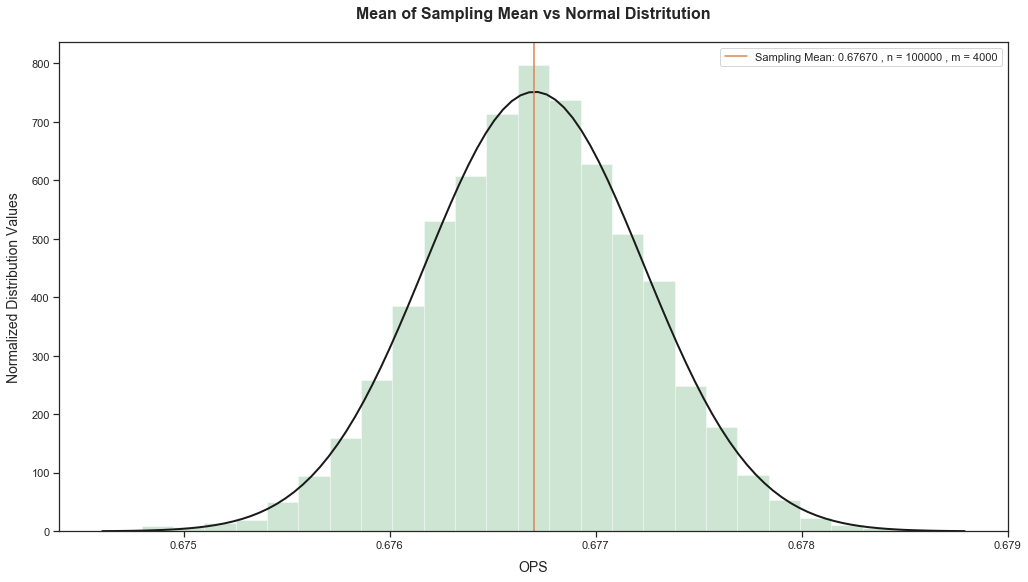

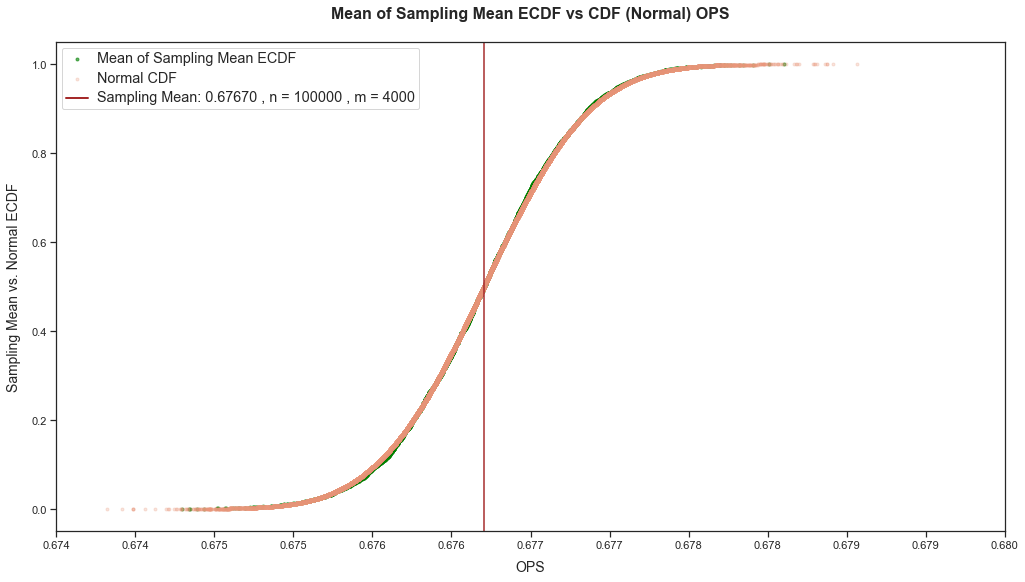

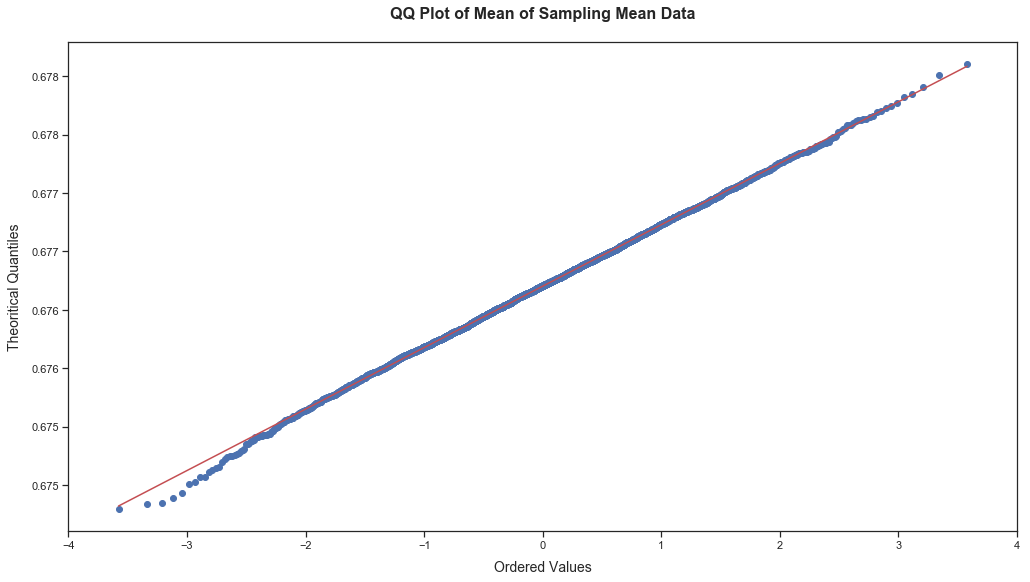




Two Tests for Null Hypothesis (H0) that Layman OPS Mean of Sample Means is Normal


DAgostinos K^2 Test:

Statistics=2.744, p=0.254
Data looks normal (fail to reject H0)


Anderson Darling Test:

Statistic: 0.217
15.000: 0.575, Data looks normal (fail to reject H0)
10.000: 0.655, Data looks normal (fail to reject H0)
5.000: 0.786, Data looks normal (fail to reject H0)
2.500: 0.917, Data looks normal (fail to reject H0)
1.000: 1.091, Data looks normal (fail to reject H0)





In [11]:
data = df[(df['OPS'] <= 1.5) & (df['OPS'] > 0.0)]
data = np.array(data.OPS)
mu = np.mean(data)
sigma = np.std(data)
seed(61)
n=100000
m=4000
sqrtn = np.sqrt(n)
meanarr = np.array([np.mean(OPS_samples(data,n)) for i in range(m)])
_ = plt.hist(meanarr, bins=25, alpha=0.4, density=True, color='#86bf91')
samplingmean = np.mean(meanarr)
samplingsigma = sigma/sqrtn
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, samplingmean, samplingsigma)
plt.plot(x, y, 'k', linewidth=2)
_ = plt.title('Mean of Sampling Mean vs Normal Distritution\n',weight='bold', size=16)
_ = plt.xlabel('OPS', labelpad=10, size=14)
_ = plt.ylabel('Normalized Distribution Values', labelpad=10, size = 14)
lab = 'Sampling Mean: %1.5f' % mu + ' , n = ' + str(n) + ' , m = ' + str(m)
plb.axvline(mu,c='C1',label=lab, color='#66b3ff')
leg = plt.legend()
plt.show()

# ECDF and norm CDF
x_ops, y_ops = ecdf(meanarr)
samplingmean = np.mean(x_ops)
samplingsigma = np.std(data)/np.sqrt(n)
sample = np.random.normal(samplingmean, samplingsigma, size=100000)
x_n, y_n = ecdf(sample)
_ = plt.plot(x_ops,y_ops,marker='.',linestyle='none',color='green',alpha=.6, label='Mean of Sampling Mean ECDF')
_ = plt.plot(x_n, y_n, marker='.',linestyle='none', label = 'Normal CDF',color='darksalmon',alpha=.25)
_ = plt.title('Mean of Sampling Mean ECDF vs CDF (Normal) OPS\n',weight='bold', size=16)
_ = plt.xlabel('OPS', labelpad=10, size=14)
_ = plt.ylabel('Sampling Mean vs. Normal ECDF', labelpad=10, size = 14)
lab = 'Sampling Mean: %1.5f' % mu + ' , n = ' + str(n) + ' , m = ' + str(m)
plb.axvline(samplingmean,label=lab, color='brown')
leg = plt.legend()
plt.xticks(np.arange(.6740,.6800,.0005))
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
# get the individual lines inside legend and set line width
for line in leg.get_lines():
    line.set_linewidth(2)
# get label texts inside legend and set font size
for text in leg.get_texts():
    text.set_fontsize('large')
plt.show()

probplot(meanarr,dist="norm",plot=plb)
_ = plt.title('QQ Plot of Mean of Sampling Mean Data\n',weight='bold', size=16)
_ = plt.xlabel('Ordered Values', labelpad=10, size=14)
_ = plt.ylabel('Theoritical Quantiles', labelpad=10, size = 14)
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
plt.xticks(np.arange(-4,5,1))
plb.show()

# perform a number of tests on layman population OPS data
print('\n\n')
print('Two Tests for Null Hypothesis (H0) that Layman OPS Mean of Sample Means is Normal\n\n')
# D'Agostinos K^2 Test
stat, p = normaltest(meanarr)
print('D''Agostinos K^2 Test:\n')
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p < alpha:
    print("Data does not look normal (reject H0)")
else:
    print("Data looks normal (fail to reject H0)")
print('\n')
# Anderson Darling test
result = anderson(meanarr)
print('Anderson Darling Test:\n')
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, Data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, Data does not look normal (reject H0)' % (sl, cv))
print('\n\n')

As you can see, the results are fantastic.  This now gives us a model where by hypothesis testing can be performed.  Moving forward this will be used during the statical modeling phase of the project.  

Also, when the data discovery was performed, the scatter plots really did not show much in regards to any correlations.  The next few plots shows some scatter plots and uses the Pearson Correlation to determine the strength of correlation.  You can review the data discovery by clicking on the following link.

https://nbviewer.jupyter.org/github/paulscheibal/SBDataScienceCert/blob/master/CapstoneP1/Discovery/DataStory.ipynb

It was determined that too much data was on the scatter plots during data discovery.  Players with great OPS stats, some with good stats and some with average and poor OPS stats were all mixed together.  What this then showed was a big blob of dots with no apparent trend.  I have broken out the OPS data by the average OPS per player according to the classifications defined in the data discovery work as follows:

                 Excellent      .9000 and above
                 Very Good      .8334 to .8999
                 Above Average  .7667 to .8333
                 Average        .7000 to .7666
                 Below Average  .6334 to .6999
                 Poor           .5667 to .6333
                 Very Poor      .5666 and Lower

The following is an example of players who have an average OPS of .8334 or higher.  This respresents the high performance batters in major league baseball from 1954 to 2018.  The following plots include only players who have played at least 12 years in major league baseball.  See data discovery Jupyter Notebook for my reasoning.

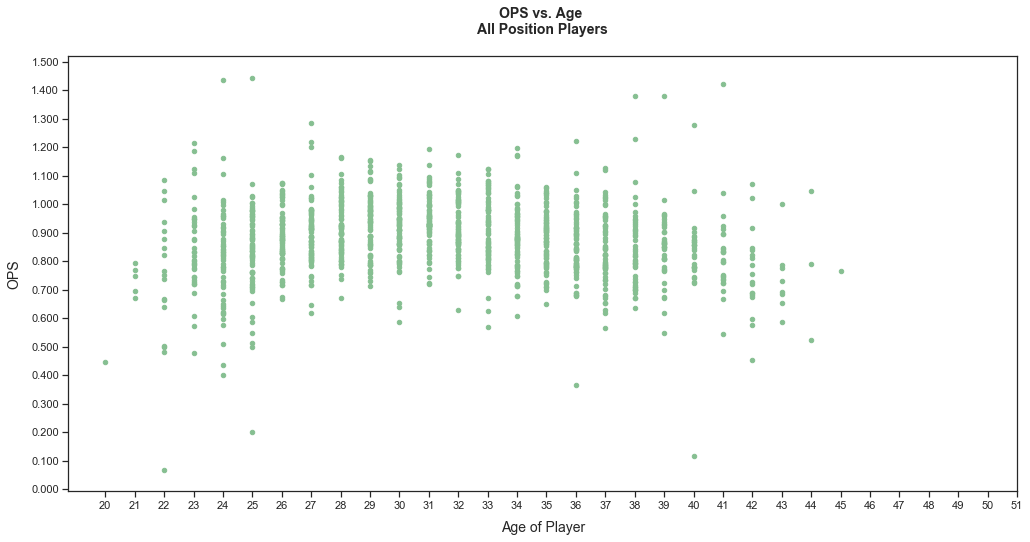

Pearson Correlation:  -0.054


In [12]:
#
#############################################################################################################
#
#  scatter plots for various cross sections of data looking for a good Pearson Correlation
#
#############################################################################################################
#
# Scatter plot for players playing for 12 or more years by OPS vs Age
dfplot = df[ (df['OPS_AVG'] >= .8334) & (df['years_played'] >= 12) & (df['OPS'] < 1.5) & (df['age'] >= 20)][['OPS','age']]
dfplot.age = dfplot.age.round()
ax = dfplot.plot(kind='scatter',x='age',y='OPS',color='#86bf91', figsize=(FSHZ,8))
ax.set_title('OPS vs. Age \nAll Position Players\n', weight='bold', size=14)
ax.set_xlabel("Age of Player", labelpad=10, size=14)
ax.set_ylabel("OPS", labelpad=10, size=14)
for tick in ax.get_xticklabels():
    tick.set_fontsize(11)
for tick in ax.get_yticklabels():
    tick.set_fontsize(11)
plt.yticks(np.arange(0,1.6,.1))
plt.xticks(np.arange(20,52,1))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
plt.show()

sage = np.array(dfplot.age)
sops = np.array(dfplot.OPS)

cov = myCovariance(sage,sops)
pcorr = myPearson_Corr(cov, sage, sops)
print('Pearson Correlation:  %.3f' % pcorr)

On the surface this looks to be a poor correlation.  But observing the data shows an upswing in OPS performance during the players younger years and then a downswing in performance during the player's latter years.  Their peak performance is reached somewhere between 28 and 31.  

Here are the results from players in the average OPS performance classes of .7000 to 7666 OPS.

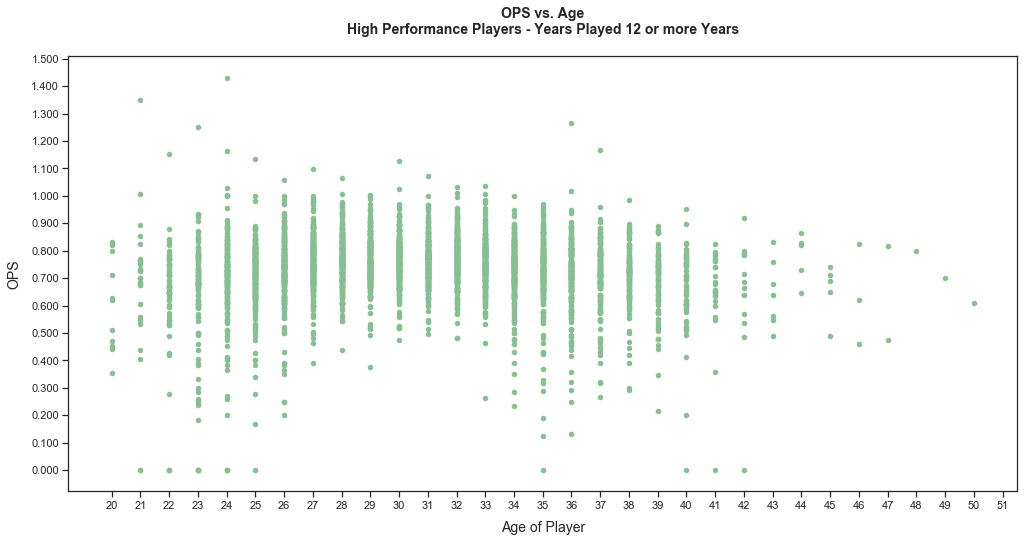

Pearson Correlation -0.007


In [13]:
# Scatter plot for players playing for 12 or more years by OPS vs Age 
dfplot = df[ (df['OPS_AVG'] >= .7000) & (df['OPS_AVG'] <= .7666) & (df['years_played'] >= 12) & (df['OPS'] < 1.5) & (df['age'] >= 20)][['OPS','age']]
dfplot.age = dfplot.age.round()
ax = dfplot.plot(kind='scatter',x='age',y='OPS',color='#86bf91', figsize=(FSHZ,8))
ax.set_title('OPS vs. Age\nHigh Performance Players - Years Played 12 or more Years\n', weight='bold', size=14)
ax.set_xlabel("Age of Player", labelpad=10, size=14)
ax.set_ylabel("OPS", labelpad=10, size=14)
for tick in ax.get_xticklabels():
    tick.set_fontsize(11)
for tick in ax.get_yticklabels():
    tick.set_fontsize(11)
plt.yticks(np.arange(0,1.6,.1))
plt.xticks(np.arange(20,52,1))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
plt.show()

sage = np.array(dfplot.age)
sops = np.array(dfplot.OPS)

cov = myCovariance(sage,sops)
pcorr = myPearson_Corr(cov, sage, sops)
print('Pearson Correlation %.3f' % pcorr)

Again, this class of player with average OPS performance between .7000 and .7666 (average player) has a upswing and then a downswing in performance.  

Let's take the high performance player with average OPS greater or equal to than .83334, but only include the data from age 28 and older.  This is the downswingof their performance in their career.

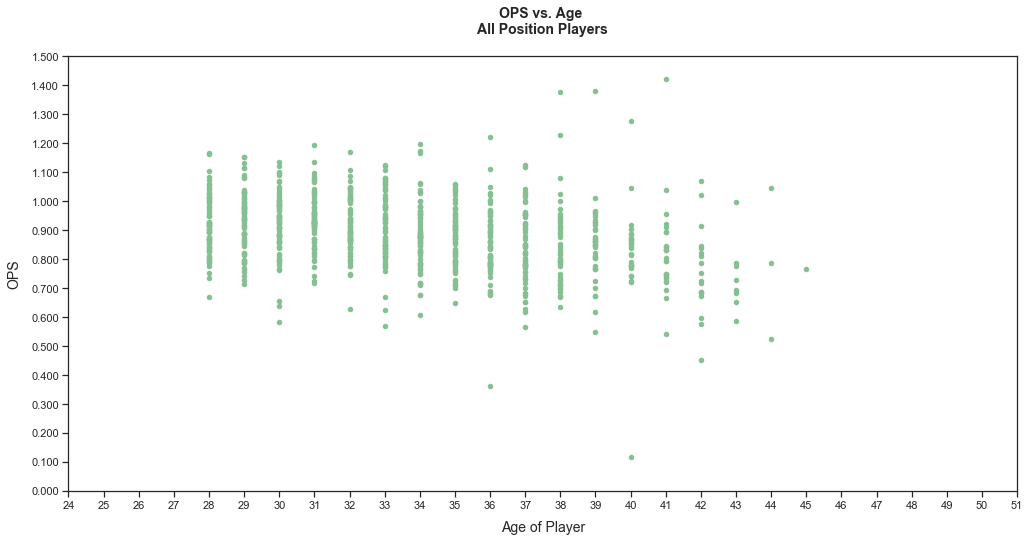

Pearson Correlation -0.325


In [14]:
# Scatter plot for players playing for 12 or more years by OPS vs Age (28 or older)
dfplot = df[ (df['OPS_AVG'] >= .8334) & (df['years_played'] >= 12) & (df['OPS'] < 1.5) & (df['age'] >= 28)][['OPS','age']]
dfplot.age = dfplot.age.round()
ax = dfplot.plot(kind='scatter',x='age',y='OPS',color='#86bf91', figsize=(FSHZ,8))
ax.set_title('OPS vs. Age \nAll Position Players\n', weight='bold', size=14)
ax.set_xlabel("Age of Player", labelpad=10, size=14)
ax.set_ylabel("OPS", labelpad=10, size=14)
for tick in ax.get_xticklabels():
    tick.set_fontsize(11)
for tick in ax.get_yticklabels():
    tick.set_fontsize(11)
plt.yticks(np.arange(0,1.6,.1))
plt.xticks(np.arange(24,52,1))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
plt.show()

sage = np.array(dfplot.age)
sops = np.array(dfplot.OPS)

cov = myCovariance(sage,sops)
pcorr = myPearson_Corr(cov, sage, sops)
print('Pearson Correlation %.3f' % pcorr)

Now the correlation is much stronger (high side of middle of the road).  It is a negative correlation. This is showing that if you look at high performance players, their performance starts to decline between the ages of 28 and 31 in general.  

The final three scatter plots plot combined OPS by age and by years played.  This reduces the granularity greatly but also reveals good coorelation information.

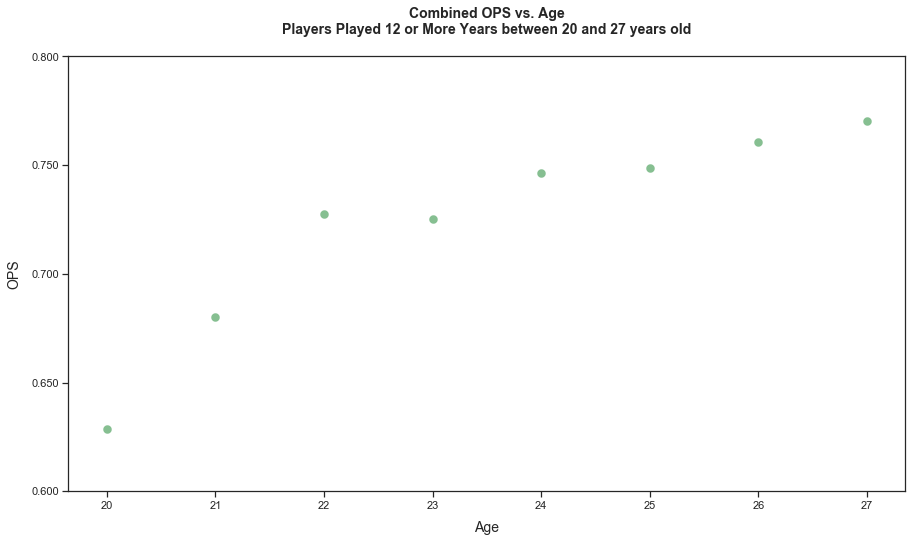

Pearson Correlation 0.913


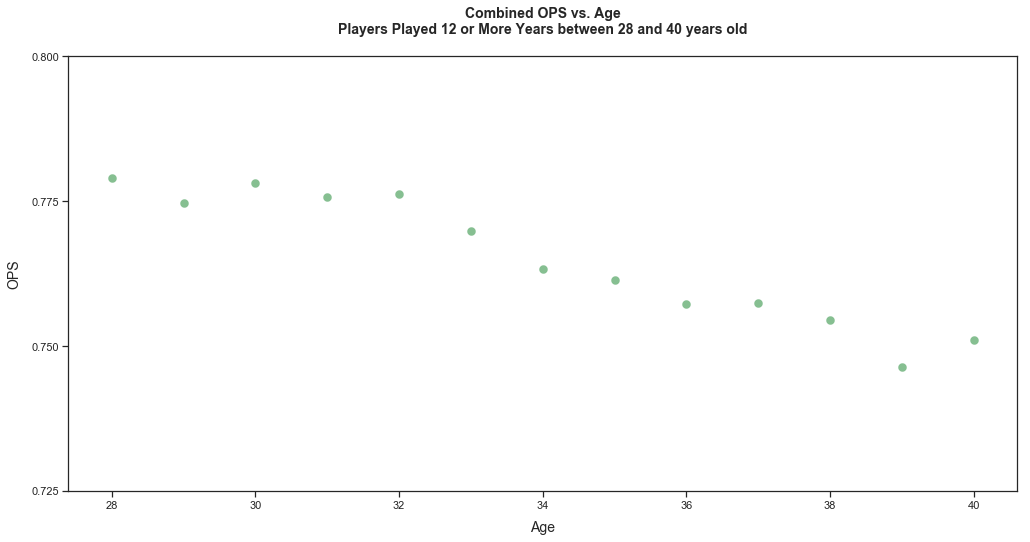

Pearson Correlation -0.962


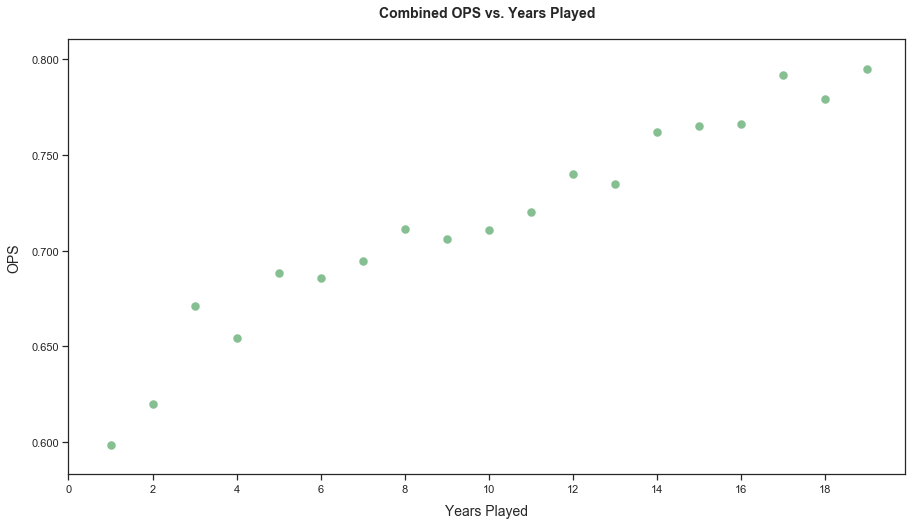

Pearson Correlation 0.971


In [15]:
# Combined OPS vs Age scatter plot; age 20 to 27
dfplot = df[(df['years_played'] >= 12) & (df['age'] <= 27) & (df['age'] >= 20)][['age','POS','H','BB','HBP','AB','SF','1B','2B','3B','HR']]
dfplot = dfplot.groupby(['age']).sum()
dfplot = calc_ops(dfplot)
dfplot = dfplot.reset_index()
ax = dfplot.plot(kind='scatter',x='age',y='OPS',figsize=(15,8),linewidth=4,color='#86bf91')
ax.set_title('Combined OPS vs. Age\nPlayers Played 12 or More Years between 20 and 27 years old\n',weight='bold', size=14)
ax.set_xlabel("Age", labelpad=10, size=14)
ax.set_ylabel("OPS", labelpad=10, size=14)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
plt.yticks(np.arange(.600,.850,.050))
plt.show()
#calculate Pearson Correlation
sage = np.array(dfplot.age)
sops = np.array(dfplot.OPS)
cov = myCovariance(sage,sops)
pcorr = myPearson_Corr(cov, sage, sops)
print('Pearson Correlation %.3f' % pcorr)

# Combined OPS vs Age scatter plot; age >= 28
dfplot = df[(df['years_played'] >= 12) & (df['age'] <= 40) & (df['age'] >= 28)][['age','POS','H','BB','HBP','AB','SF','1B','2B','3B','HR']]
dfplot = dfplot.groupby(['age']).sum()
dfplot = calc_ops(dfplot)
dfplot = dfplot.reset_index()
ax = dfplot.plot(kind='scatter',x='age',y='OPS',figsize=(FSHZ,8),linewidth=4,color='#86bf91')
ax.set_title('Combined OPS vs. Age\nPlayers Played 12 or More Years between 28 and 40 years old\n',weight='bold', size=14)
ax.set_xlabel("Age", labelpad=10, size=14)
ax.set_ylabel("OPS", labelpad=10, size=14)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
plt.yticks(np.arange(.725,.800,.025))
plt.show()
#calculate Pearson Correlation
sage = np.array(dfplot.age)
sops = np.array(dfplot.OPS)
cov = myCovariance(sage,sops)
pcorr = myPearson_Corr(cov, sage, sops)
print('Pearson Correlation %.3f' % pcorr)

# Combined OPS vs years played of athelets between the age of 28 and 40
dfplot = df[(df['age'] <= 40) & (df['age'] >= 28) & (df['years_played'] < 20)][['years_played','POS','H','BB','HBP','AB','SF','1B','2B','3B','HR']]
dfplot = dfplot.groupby(['years_played']).sum()
dfplot = dfplot.reset_index()
dfplot = calc_ops(dfplot)
dfplot = dfplot.reset_index()
ax = dfplot.plot(kind='scatter',x='years_played',y='OPS',figsize=(15,8),linewidth=4,color='#86bf91')
ax.set_title('Combined OPS vs. Years Played\n',weight='bold', size=14)
ax.set_xlabel("Years Played", labelpad=10, size=14)
ax.set_ylabel("OPS", labelpad=10, size=14)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
plt.yticks(np.arange(.600,.850,.050))
plt.xticks(np.arange(0,20,2))
plt.show()
#calculate Pearson Correlation
sage = np.array(dfplot.years_played)
sops = np.array(dfplot.OPS)
cov = myCovariance(sage,sops)
pcorr = myPearson_Corr(cov, sage, sops)
print('Pearson Correlation %.3f' % pcorr)

As you can see in the first two plots, the player performance improves over time from ages 20 to 27.  At about 28 to 31 years of age, the player's performance starts to decline.  In their  The last slide shows that players who play more years tend to be the better batting performers which makes complete sense. Your not going to last long as a position player if you can't hit.